#  Pothole detector 
## Bottleneck Features

### 1. Load the VGG16 model pre-trained on ImageNet
Weights are automatically downloaded if not already present

In [1]:
from keras.applications.vgg16 import VGG16
# create the VGG16 model with only the convolutional layers, and using weights from ImageNet
model = VGG16(include_top=False,weights='imagenet')
# show architecture
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### 2. Load and visualise sample of dataset

number of images: 4026


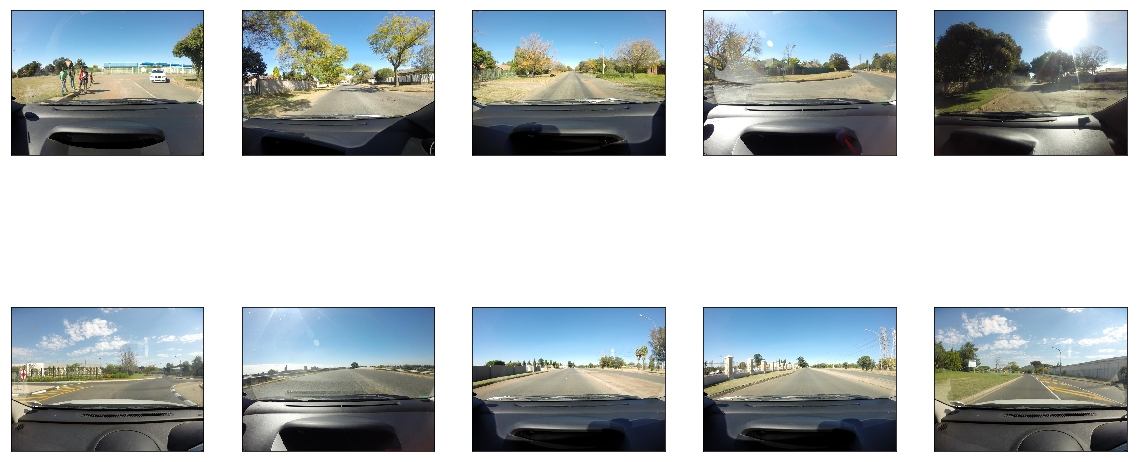

In [2]:
import glob
import cv2
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(0)

positive_data = glob.glob("hackathon_public/data/train/positive/*")
negative_data = glob.glob("hackathon_public/data/train/negative/*")

# create binary targets based on positive/negative data
training_data = list(zip(positive_data,[1]*len(positive_data))) + list(zip(negative_data,[0]*len(negative_data)))
# shuffle training data so positive and negative are randomly ordered
# random.shuffle(training_data)
# get all the img_paths and corresponding targets
img_paths,targets = zip(*training_data)

print("number of images: {}".format(len(img_paths)))

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# show some example images (positive on top, negative below)
fig = plt.figure(figsize=(20, 10))
visual_subset_p = positive_data[5:10]
for i,img_path in enumerate(visual_subset_p):
    ax = fig.add_subplot(2, len(visual_subset_p), i + 1, xticks=[], yticks=[])
    visualize_img(img_path, ax)
visual_subset_n = negative_data[1:6]
for i,img_path in enumerate(visual_subset_n):
    ax = fig.add_subplot(2, len(visual_subset_n), i + 1+ len(visual_subset_p), xticks=[], yticks=[])
    visualize_img(img_path, ax)

### 3. Pre-processing of the images for the model


In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
import numpy as np

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

# calculate the image input
# img_input = preprocess_input(paths_to_tensor(img_paths))
img_input = paths_to_tensor(img_paths)
print(img_input.shape)

(4026, 224, 224, 3)


### 4. Get bottleneck features (output of last convolutional layer)

In [ ]:
predicted = model.predict(img_input)
print(predicted.shape)

### 5. Save features

In [ ]:
np.savez_compressed('bottelneck_features',data=predicted,targets=targets)
print("SAVED")

### 6. Do the same for the test set

In [6]:
# as before, but for test set
test_positive_data = glob.glob("data/test/positive/*")
test_negative_data = glob.glob("data/test/negative/*")
test_data = list(zip(test_positive_data,[1]*len(test_positive_data))) + list(zip(test_negative_data,[0]*len(test_negative_data)))
test_data_paths,test_targets = zip(*test_data)
img_input_test = paths_to_tensor(test_data_paths)
predicted_test = model.predict(img_input_test)
print(predicted_test.shape)
np.savez_compressed('bottelneck_features_test',data=predicted_test,targets=test_targets)

(1650, 7, 7, 512)


## The alternative way

In [7]:
# create DataGenerator Object
datagen = image.ImageDataGenerator(rescale=1./255)

# data directoies (single batch)
train_generator_b = datagen.flow_from_directory(
        'data/train/',
        target_size=(224, 224),
        class_mode='binary',
        shuffle=False,
        seed=0,
        batch_size=len(img_paths))
test_generator_b = datagen.flow_from_directory(
        'data/test/',
        target_size=(224, 224),
        class_mode='binary',
        shuffle=False,
        seed=0,
        batch_size=len(test_data_paths))

for imgs,labels_batch in train_generator_b:
    data = model.predict(imgs)
    labels = labels_batch
    # break else it will go infinitely (hence batch size == sample size)
    break
for imgs,labels_batch in test_generator_b:
    test_data = model.predict(imgs)
    test_labels = labels_batch   
    break
print("data.shape",data.shape)
print("test_data.shape",test_data.shape)

Found 4026 images belonging to 2 classes.
Found 1650 images belonging to 2 classes.
data.shape (4026, 7, 7, 512)
test_data.shape (1650, 7, 7, 512)


In [8]:
print(sum(labels),'==',len(positive_data))
print(sum(test_labels),'==',len(test_positive_data))

1661.0 == 1661
650.0 == 650


In [9]:
np.savez_compressed('bottleneck_features',data=data,targets=labels)
np.savez_compressed('bottleneck_features_test',data=test_data,targets=test_labels)
print("SAVED")

SAVED
